In [1]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

In [2]:
import jax
import flax
import jax.numpy as jnp
import flax.linen as nn

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [3]:
from jax_flows.blocks import FlowStep, Sequential
from jax_flows.affine import AffineCoupling
from jax_flows.subnets import MlpSubnet
from jax_flows.permutations import FixedPermutation

from jax_flows.priors import Normal
from jax_flows.flow import Flow

In [4]:
def p(t):
    
    a,b,c,d,e,f,g,h = -0.0687857495947557,-0.6648650500627475,0.815347080763398,0.19494178563189268,-0.854424285284626,-0.020504147263712413,0.5816050753257676,0.11819142693558216
    
    x = np.sin(a*t**3 + b*t**2 + c*t + d)
    y = np.sin(e*t**3 + f*t**2 + g*t + h)
    
    return x,y

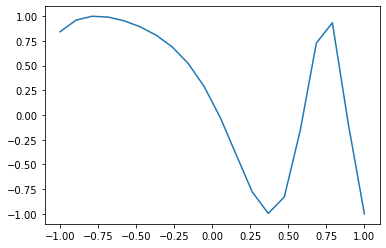

In [52]:
def q(x):
    
    
    
    return x,y

t = np.linspace(-1,1,20)
x,y = q(t)

plt.plot(x,y)

In [36]:
def get_samples(n_samples,noise=None):
    
    t = np.random.uniform(low=-1.8,high=1.8,size=n_samples).reshape(-1,1)
    
    x,y = p(t)
    
    if noise:
        x += np.random.normal(size=x.shape)*noise
        y += np.random.normal(size=x.shape)*noise
    
    data = np.concatenate([x.reshape(-1,1),y.reshape(-1,1)],axis=1)
    
    return data,t


def fourier_encode(x, max_freq, num_bands = 4, base = 2):
    x = jnp.expand_dims(x,-1)
    dtype, orig_x = x.dtype, x

    scales = jnp.logspace(0., jnp.log(max_freq / 2) / jnp.log(base), num_bands, base = base, dtype = dtype)
    scales = scales[(*((None,) * (len(x.shape) - 1)), Ellipsis)]

    x = x * scales * jnp.pi
    x = jnp.concatenate([jnp.sin(x), jnp.cos(x)], axis =-1)
    x = jnp.concatenate((x, orig_x), axis = -1)
    return x

def create_data(n_samples=30):
    
    data,t = get_samples(n_samples=n_samples,noise=0.00)
    
#     x = jnp.squeeze(fourier_encode(t,max_freq=5,num_bands=1,base=2))
#     y = jnp.array(np.concatenate((t,data),axis=1))
    
    x = jnp.array(np.concatenate((t,np.zeros((n_samples,3))),axis=1))
    y = jnp.array(np.concatenate((t,data,np.zeros((n_samples,1))),axis=1))
    
    return x,y

In [ ]:
data,t = get_samples(n_samples=30,noise=0.00)

t = jnp.linspace(-1,1,30)
x = fourier_encode(t,max_freq=5,num_bands=1,base=2)
print(x.shape)

plt.plot(np.squeeze(x))

In [ ]:
from functools import partial

class vanilla(nn.Module):

    mlp_width: int # Width of mlp subnetworks
    mlp_depth: int
    num_mlp_layers: int
    key: jax.random.PRNGKey = jax.random.PRNGKey(0)

    def setup(self):
        keys = jax.random.split(self.key,self.num_mlp_layers)        
        subnet = partial(MlpSubnet,width=self.mlp_width,depth=self.mlp_depth)
        self.modules = [FlowStep(subnet,key,permutation=FixedPermutation,norm=None) for key in keys]
        
    @nn.compact
    def __call__(self, x, reverse=False, num_modules=None):
        """Args:
            * x: Input to the model
            * reverse: Whether to apply the model or its inverse
        """
        
        x, logdets = Sequential(self.modules)(x, reverse=reverse, num_modules=num_modules)
        return x, logdets


In [ ]:
x,y = create_data(n_samples=20)


In [42]:
key = jax.random.PRNGKey(0)

# bijection = vanilla(mlp_width=512,num_mlp_layers=4)
# prior = Normal(shape=(4,),temperature=0.7)
# model = Flow(prior=prior,bijection=bijection,key=key)

model = vanilla(mlp_width=512,mlp_depth=1,num_mlp_layers=6)
params = model.init(key, x)

opt = flax.optim.Adam(learning_rate=0.001).create(params)


@jax.jit
def loss_fn(params):
    ypred, logdet = model.apply(params,x)
    return jnp.sum((ypred - y)**2)

# @jax.jit
def step(params):
    grad_fn = jax.value_and_grad(loss_fn)
    loss,grad = grad_fn(params)
    return loss, grad

In [ ]:
num_iters = 10000

pbar = tqdm(range(num_iters))

for it in pbar:
    
    loss,grad = step(opt.target)
    opt = opt.apply_gradient(grad)
    pbar.set_description(f'Loss: {loss: 0.2f}')
    
    if it % 20 == 0:
        show_results(opt.target)
    
params = opt.target

In [39]:
def show_results(params):
    
    npoints = 1000
    z = np.zeros((npoints,4))
    z[:,0] = np.linspace(-1.8,1.8,npoints)
#     t = jnp.linspace(-1.8,1.8,30)
#     z = jnp.squeeze(fourier_encode(t,max_freq=5,num_bands=1,base=2))

    fig,ax = plt.subplots(figsize=(8,8))

    ax.axis([-1.1,0.75,-1.1,1.1])

    samples, _ = model.apply(params,z)
    ax.plot(samples[:,1],samples[:,2],'-')

    x_,y_ = p(np.linspace(-1.8,1.8,200))
    ax.plot(x_,y_,'.-')

    ax.plot(y[:,1],y[:,2],'o')
    
    plt.show()

In [31]:
params = opt.target

In [18]:
samples

DeviceArray([[-1.8      ,  0.       ,  0.       ,  0.       ],
             [-1.7963964,  0.       ,  0.       ,  0.       ],
             [-1.7927928,  0.       ,  0.       ,  0.       ],
             ...,
             [ 1.7927928,  0.       ,  0.       ,  0.       ],
             [ 1.7963964,  0.       ,  0.       ,  0.       ],
             [ 1.8      ,  0.       ,  0.       ,  0.       ]],            dtype=float32)

In [45]:
loss_fn(params)

DeviceArray(56.122734, dtype=float32)